In [1]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m
import seaborn as sns

# make plt plot inline
%matplotlib inline

In [2]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'  # path to data folder

Old calibration

In [14]:
am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + 'lead2_extended.chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_new/channel_counts.chn')

channels = calibration_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 


folder_path = user_path + '/PHYS469/alpha_decay/raw_data/calibration_new'

# making an array of channel-voltage pairs, where the channel is the file name and the voltage is the peak y value in each file 
# txt files, headers are on row 29

# get all the files in the folder
files = os.listdir(folder_path)

# sort the files by channel number
files.sort()
files.remove('channel_counts.Chn')

# initialize the array
pulser_voltages = []
pulser_channels = []

# loop through the files
for file in files:
    # read the file
    data = np.genfromtxt(folder_path + '/' + file, skip_header=29)
    # get the peak y value
    peak = max(data[:,1])
    # # get the channel number
    channel = int(file.split('.')[0])
    # # add the pair to the array
    pulser_voltages.append(peak)
    pulser_channels.append(channel)

voltage_err = 0.0001

In [15]:
def line(channels, m, b):
    channels = np.array(channels)
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# fit the calibration data
popt, pcov = opt.curve_fit(line, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

In [16]:
# Converting to energy scale
voltages = m * channels + b

# error propagation from fit onto voltages
voltage_err = np.sqrt(channel**2 * m_err**2 + b_err**2)

am_peak_energy = 5.486 # MeV
am_peak_channel = channels[am_peak]

am_peak_voltage = m * am_peak_channel + b
am_peak_voltage_err = 0.0001 # from measurements

energy = am_peak_energy * voltages / am_peak_voltage
energy_err = energy * np.sqrt((am_peak_voltage_err/am_peak_voltage)**2 + (voltage_err/voltages)**2)

In [17]:
# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 500:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print(f'The peaks are at channels: {peaks}, corresponding to energies: {energy[peaks]} +- {energy_err[peaks]} MeV.')


The peaks are at channels: [521, 751], corresponding to energies: [6.07684353 8.74143202] +- [0.04564538 0.04564614] MeV.


Load pressure data

In [13]:
pressure_data_dict = {}
for file in os.listdir(folder_path + 'pressure_new/'):
    p = file.split('.')[0]
    pressure_data_dict[p] = m.data.load_chn(folder_path + 'pressure_new/' + f'{p}.Chn')

pressure_data_dict.keys()

dict_keys(['50mbar', '175millitorr', '250mbar', '100mbar', '150mbar', '200mbar', '2000millitorr', '80millitorr', '400millitorr'])

Path length

In [ ]:
# calculate dx & error


Get the peaks

In [57]:
def get_peaks(counts):
    # find peaks in the data
    peaks_ind = []
    max_first = np.max(counts[400:600])
    for i in range(1, len(counts) - 1000):
        if counts[i] > max_first-50:
            if counts[i] > counts[i - 1] and counts[i] > counts[i + 1]:
                peaks_ind.append(i)
    
    return peaks_ind

In [81]:
first_peak_energy = []
first_peak_err = []
second_peak_energy = []
second_peak_err = []
pressures = []  # pressures in mbar

for p in pressure_data_dict.keys():
    # convert pressure to mbar
    p_mbar = int(p.split('mbar')[0]) if 'mbar' in p else int(p.split('millitorr')[0])/750.062
    pressures.append(p_mbar)

    # find peaks in the data
    peaks = get_peaks(pressure_data_dict[p].columns['Counts'])
    # print(f'{p}: {peaks}')

    # get the energy of the peaks
    first_peak_energy.append(energy[peaks[0]])
    first_peak_err.append(energy_err[peaks[0]])
    second_peak_energy.append(energy[peaks[1]])
    second_peak_err.append(energy_err[peaks[1]])

# make arrays
pressures = np.array(pressures)
first_peak_energy = np.array(first_peak_energy)
second_peak_energy = np.array(second_peak_energy)

Plot

- want a 2 panel plot, each panel is a peak
- plot a scatter of the energy of the peak as a function of pressure
- add a (linear?) fit, and the 2 theoretical curves

$$ \Delta E = E_{low P} - E_{high P} $$

In [119]:
# Reference pressures
lowest_p_ind = np.argmin(np.abs(pressures - 0))
ref_energy_1 = first_peak_energy[lowest_p_ind]
ref_energy_2 = second_peak_energy[lowest_p_ind]

# New energy arrays
first_peak_deltaE = ref_energy_1 - first_peak_energy
second_peak_deltaE = ref_energy_2 - second_peak_energy

In [120]:
# Linear fits
def line(x, m, b):
    return m * x + b

# First peak
popt_1, pcov_1 = opt.curve_fit(line, pressures, first_peak_deltaE, p0=[-0.01, 1])
m1, b1 = popt_1
m_err_1 = np.sqrt(pcov_1[0,0])
b_err_1 = np.sqrt(pcov_1[1,1])
print(f'First peak: m = {m1:.6f} +- {m_err_1:.6f}, b = {b1:.6f} +- {b_err_1:.6f}')

# Second peak
popt_2, pcov_2 = opt.curve_fit(line, pressures, second_peak_deltaE, p0=[1, 0])
m2, b2 = popt_2
m_err_2 = np.sqrt(pcov_2[0,0])
b_err_2 = np.sqrt(pcov_2[1,1])
print(f'Second peak: m = {m2:.6f} +- {m_err_2:.6f}, b = {b2:.6f} +- {b_err_2:.6f}')

First peak: m = 0.002902 +- 0.000059, b = 0.009304 +- 0.007268
Second peak: m = 0.002173 +- 0.000051, b = 0.004691 +- 0.006342


In [ ]:
# GET THE THEORETICAL CURVES

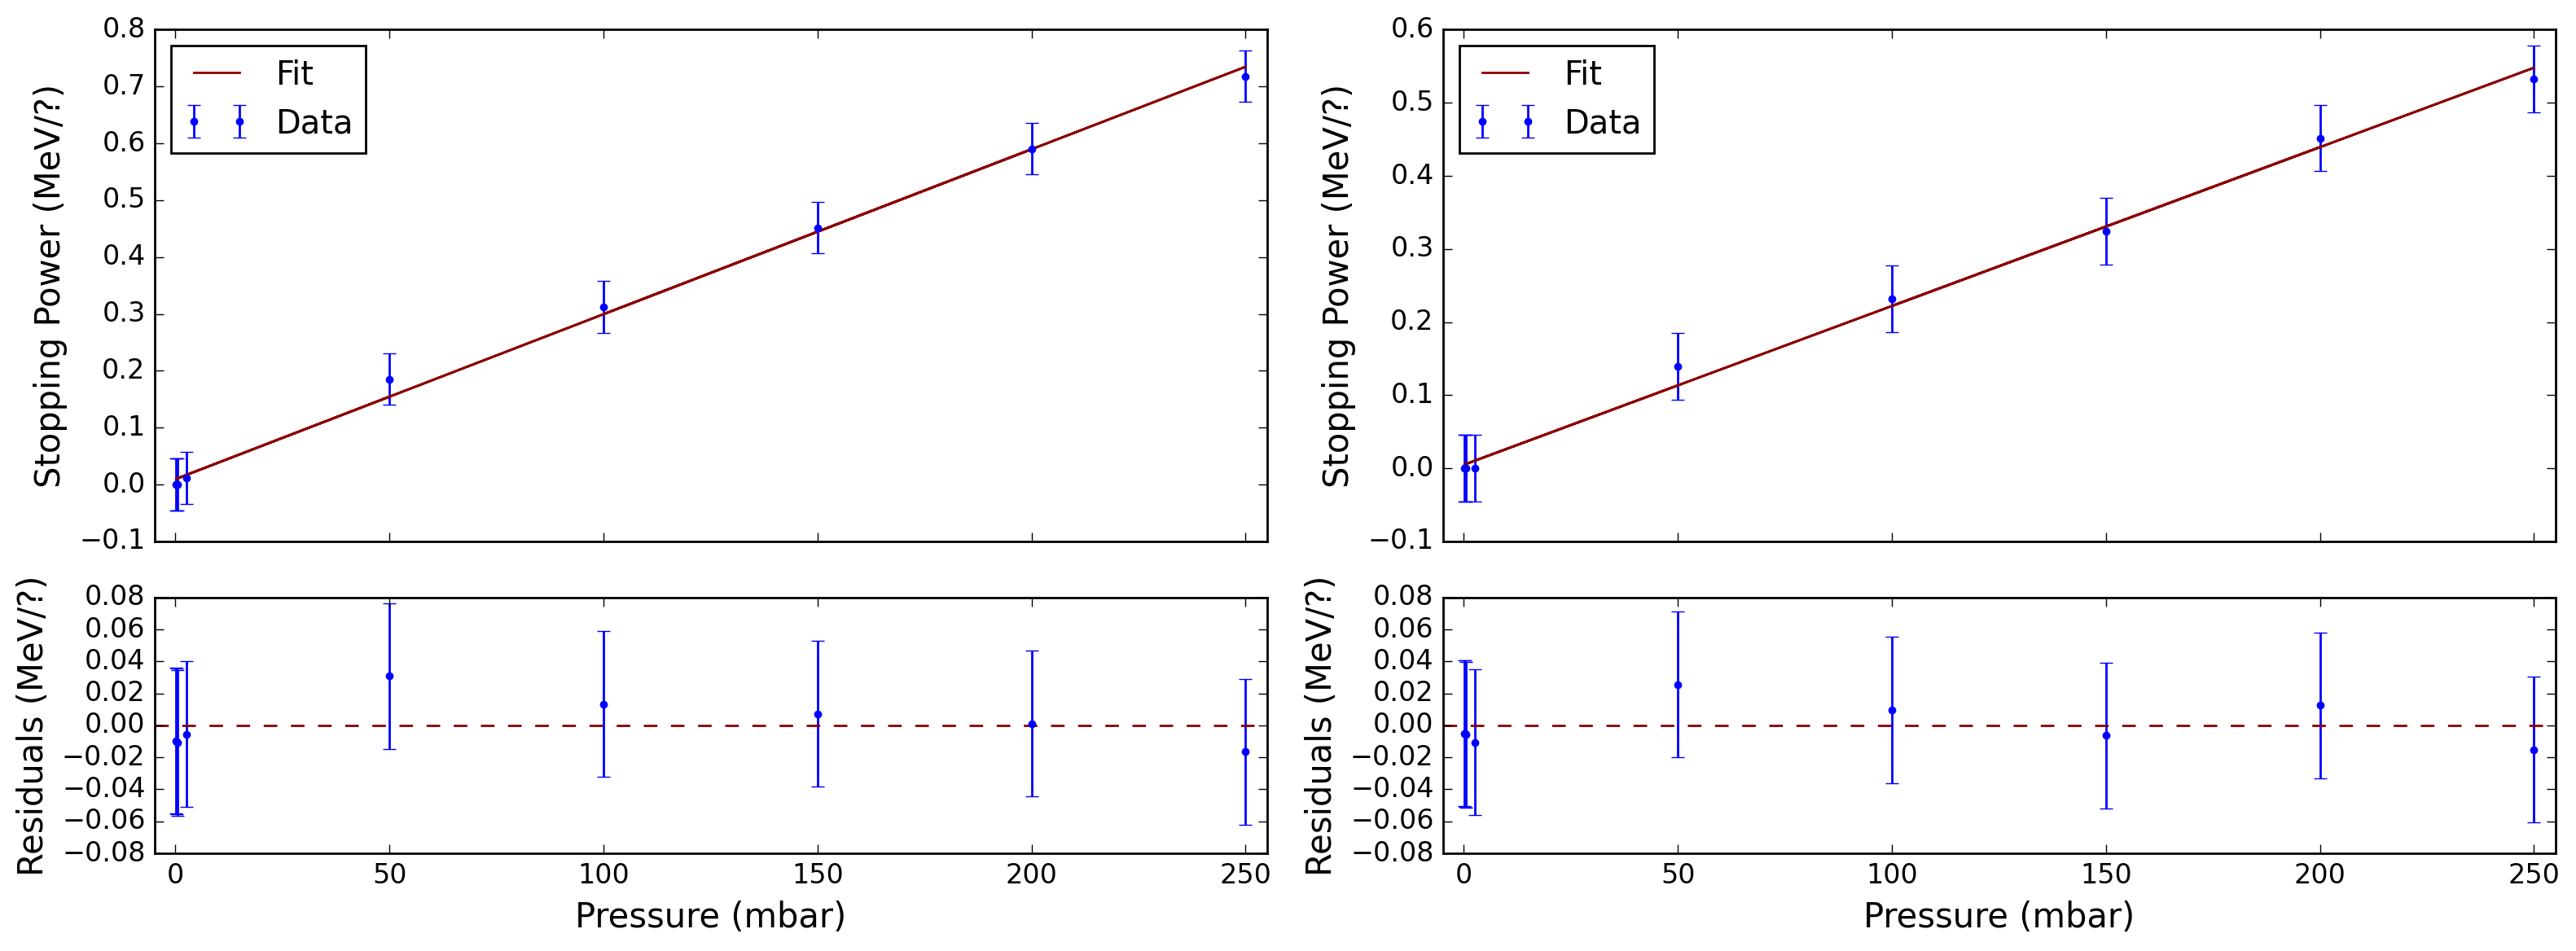

In [123]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 6), dpi=200, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# CHANGE ERROR BARS TO BE FOR dE/dx INSTEAD OF dE

# First peak
axes[0,0].errorbar(pressures, first_peak_deltaE, yerr=first_peak_err, fmt='.', label='Data')
axes[0,0].plot(pressures, line(pressures, m1, b1), color='darkred', label='Fit')
# Residuals
axes[1,0].errorbar(pressures, first_peak_deltaE - line(pressures, m1, b1), yerr=first_peak_err, fmt='.')
axes[1,0].axhline(0, color='darkred', linestyle='--')

# Second peak
axes[0,1].errorbar(pressures, second_peak_deltaE, yerr=second_peak_err, fmt='.', label='Data')
axes[0,1].plot(pressures, line(pressures, m2, b2), color='darkred', label='Fit')
# Residuals
axes[1,1].errorbar(pressures, second_peak_deltaE - line(pressures, m2, b2), yerr=second_peak_err, fmt='.')
axes[1,1].axhline(0, color='darkred', linestyle='--')

# Labels
for ax in axes[0]:
    ax.set_ylabel('Stopping Power (MeV/?)', fontsize=15)
    ax.legend(loc='upper left')
for ax in axes[1]:
    ax.set_xlim(np.min(pressures)-5,np.max(pressures)+5)
    ax.set_xlabel('Pressure (mbar)', fontsize=15)
    ax.set_ylabel('Residuals (MeV/?)', fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
# CHI SQUARE FOR FITS